In [41]:
# Allow to load the `adaptive cover` module from this notebook
import sys

sys.path.append("../custom_components")

from datetime import date, timedelta  # noqa: F401  # noqa: F401
from pvlib import solarposition  # noqa: F401
import pandas as pd
import numpy as np  # noqa: F401
import matplotlib.pyplot as plt  # noqa: F401
from adaptive_cover_pro.calculation import AdaptiveVerticalCover, AdaptiveHorizontalCover  # type: ignore
from adaptive_cover_pro.sun import SunData  # type: ignore

# Adaptive Cover Algorithm Testing

This notebook provides interactive testing and visualization of the Adaptive Cover calculation algorithms.

## Purpose
- Test vertical and horizontal blind position calculations without requiring Home Assistant
- Visualize how cover positions change based on sun position throughout the day
- Experiment with configuration parameters before deploying

## How to Use
1. Modify configuration variables in the next cell (timezone, lat/lon, window properties)
2. Run all cells sequentially (Cell → Run All)
3. Review the plots showing sun position and calculated cover positions

## Output Interpretation
- **Red dashed lines:** Sunrise and sunset times
- **Yellow dashed lines:** Sun enters/exits the window's field of view
- **Blue/Orange lines (primary axis):** Sun elevation and azimuth angles
- **Green line (secondary axis):** Cover opening state (0% closed → 100% open)

Location

In [42]:
# Location settings (example: Netherlands)
timezone = "America/Los_Angeles"
lat = 32.9390684322475  # Latitude in degrees
lon = -117.15618073940279  # Longitude in degrees

Integration Calculations

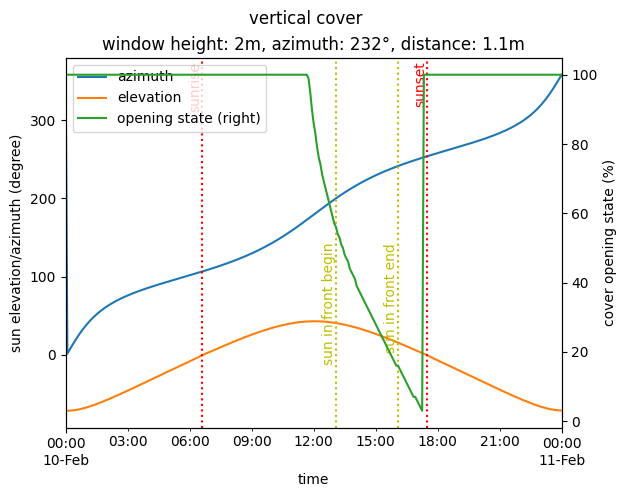

In [ ]:
# ===== CONFIGURATION: Modify these values to test different scenarios =====

# Cover position limits
maximum_position = 100  # Maximum cover opening (0=closed, 100=open)

# Window physical properties
window_height = 2  # Window height in meters
shaded_area = 1.1  # Distance from window to blind in meters
windown_azimuth = 232  # Window azimuth (0=North, 90=East, 180=South, 270=West)
window_fov_left = 32  # Field of view to the left in degrees
window_fov_right = 10  # Field of view to the right in degrees

# Default behavior
default_height = 60  # Default cover position percentage when sun not in front


class MockedHass:  # noqa: D101
    """Mock HomeAssistant instance for notebook testing."""
    class MockedConfig:  # noqa: D106
        latitude = lat
        longitude = lon
        time_zone = timezone
        elevation = 0

    config = MockedConfig()
    data = {}


class MockedLogger:  # noqa: D101
    """Mock ConfigContextAdapter for notebook testing.

    Provides the required logging interface without actual output.
    The calculation classes call logger.debug() extensively.
    """
    def debug(self, msg, *args, **kwargs):
        pass

    def info(self, msg, *args, **kwargs):
        pass

    def warning(self, msg, *args, **kwargs):
        pass

    def error(self, msg, *args, **kwargs):
        pass

    config_name = "Notebook Test"


mocked_hass = MockedHass()
mocked_logger = MockedLogger()

sun_data = SunData(timezone, mocked_hass)
sunrise_time = sun_data.location.sunrise()
sunset_time = sun_data.location.sunset()

sun_df = pd.DataFrame(
    {
        "azimuth": sun_data.solar_azimuth,
        "elevation": sun_data.solar_elevation,
    }
)
sun_df.set_index(sun_data.times, inplace=True)


def compute_cover_position(sun_data: pd.Series):  # noqa: D103
    # print(sun_data)
    vertical_cover = AdaptiveVerticalCover(
        hass=mocked_hass,
        logger=mocked_logger,
        timezone=timezone,
        sol_azi=sun_data["azimuth"],
        sol_elev=sun_data["elevation"],
        min_elevation=0,
        max_elevation=90,
        sunset_pos=30,
        sunset_off=0,
        sunrise_off=0,
        win_azi=windown_azimuth,
        fov_left=window_fov_left,
        fov_right=window_fov_right,
        h_win=window_height,
        distance=shaded_area,
        h_def=default_height,
        blind_spot_on=False,
        blind_spot_left=0,
        blind_spot_right=0,
        blind_spot_elevation=0,
        max_pos=maximum_position,
        min_pos=0,
        max_pos_bool=False,
        min_pos_bool=False,
        window_depth=0.0,
    )

    return vertical_cover.calculate_percentage(), vertical_cover.valid


sun_df[["opening state", "sun_is_on"]] = sun_df.apply(
    compute_cover_position, axis=1, result_type="expand"
)

sun_in_front_begin = sun_df[sun_df["sun_is_on"]].iloc[0].name.to_pydatetime()
sun_in_front_end = sun_df[sun_df["sun_is_on"]].iloc[-1].name.to_pydatetime()


def plot(suptitle: str):  # noqa: D103
    ax = sun_df.plot(
        secondary_y=["opening state"],
        title=f"window height: {window_height}m, azimuth: {windown_azimuth}°, distance: {shaded_area}m",
    )

    ax.set_ylabel("sun elevation/azimuth (degree)")
    ax.right_ax.set_ylabel("cover opening state (%)")

    ax.figure.suptitle(suptitle)

    ax.axvline(sunrise_time, color="r", ls=":")
    ax.text(
        sunrise_time,
        0.99,
        "sunrise",
        color="r",
        ha="right",
        va="top",
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )

    ax.axvline(sun_in_front_begin, color="y", ls=":")
    ax.text(
        sun_in_front_begin,
        0.5,
        "sun in front begin",
        color="y",
        ha="right",
        va="top",
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )

    ax.axvline(sunset_time, color="r", ls=":")
    ax.text(
        sunset_time,
        0.99,
        "sunset",
        color="r",
        ha="right",
        va="top",
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )

    ax.axvline(sun_in_front_end, color="y", ls=":")
    ax.text(
        sun_in_front_end,
        0.5,
        "sun in front end",
        color="y",
        ha="right",
        va="top",
        rotation=90,
        transform=ax.get_xaxis_transform(),
    )


plot("vertical cover")

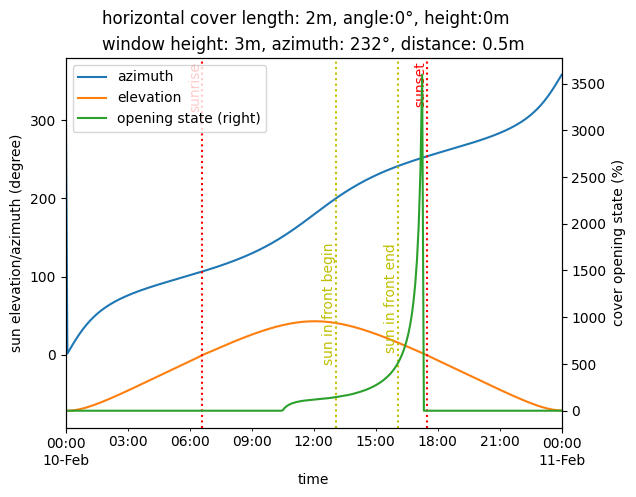

In [44]:
window_height = 3
shaded_area = 0.5

cover_awning_length = 2
cover_awning_height = 0
cover_awning_angle = 0


def compute_cover_position(sun_data: pd.Series):  # noqa: D103
    # print(sun_data)
    horizontal_cover = AdaptiveHorizontalCover(
        hass=mocked_hass,
        logger=mocked_logger,
        timezone=timezone,
        sol_azi=sun_data["azimuth"],
        sol_elev=sun_data["elevation"],
        min_elevation=0,
        max_elevation=90,
        sunset_pos=30,
        sunset_off=0,
        sunrise_off=0,
        win_azi=windown_azimuth,
        fov_left=window_fov_left,
        fov_right=window_fov_right,
        h_win=window_height,
        distance=shaded_area,
        h_def=default_height,
        blind_spot_on=False,
        blind_spot_left=0,
        blind_spot_right=0,
        blind_spot_elevation=0,
        max_pos=maximum_position,
        min_pos=0,
        max_pos_bool=False,
        min_pos_bool=False,
        window_depth=0.0,
        awn_length=cover_awning_length,
        awn_angle=cover_awning_angle,
    )
    return horizontal_cover.calculate_percentage(), horizontal_cover.valid


sun_df[["opening state", "sun_is_on"]] = sun_df.apply(
    compute_cover_position, axis=1, result_type="expand"
)

sun_in_front_begin = sun_df[sun_df["sun_is_on"]].iloc[0].name.to_pydatetime()
sun_in_front_end = sun_df[sun_df["sun_is_on"]].iloc[-1].name.to_pydatetime()

plot(
    f"horizontal cover length: {cover_awning_length}m, angle:{cover_awning_angle}°, height:{cover_awning_height}m"
)

Plots

In [45]:
# # start_date = '2022-06-05'
# # end_date = '2022-06-06'
# start_date = date.today()
# end_date = start_date + timedelta(days=1)

# times = pd.date_range(start=start_date, end=end_date, freq="5min", tz=timezone)
# solpos = solarposition.get_solarposition(times, lat, lon)

# slat_distance = 4
# depth = 6

# plot_calc = AdaptiveCoverCalculator(
#     timezone,
#     lat,
#     lon,
#     solpos["azimuth"],
#     solpos["elevation"],
#     win_azi,
#     h_win,
#     distance,
#     fov_left,
#     fov_right,
#     def_height,
#     angle,
#     l_awn,
#     slat_distance,
#     depth,
# )

Vertical

In [46]:
# blind_vertical = plot_calc.blind_state_perc()
# print(blind_vertical)
# plt.plot(blind_vertical, label='blind vertical', color='red')

Horizontal

In [47]:
# blind_horizontal = plot_calc.awn_state_perc()
# print(blind_horizontal)
# plt.plot(blind_horizontal, label='blind horizontal', color='green')

Tilt

In [48]:
# blind_tilt = plot_calc.calculate_tilt_angle
# print(blind_tilt.values)
# blind_tilt_per = plot_calc.tilt_state_perc()

In [49]:
# from astral import LocationInfo  # pylint: disable=import-outside-toplevel
# from astral.location import Location
# from astral.sun import sun

# info = LocationInfo("", "", "CET", lat, lon)
# astral_location = Location(info)
# # print(times.to_list)
# print(astral_location.solar_azimuth(times[83]))
# print(astral_location.sunset(start_date, local=False))
# test_astral = sun(info.observer, date=date.today())
# # print(test_astral)
# index = 0
# azi_list = []
# for i in times:
#     azi_list.append(Location(info).solar_azimuth(times[index]))
#     index += 1
# df_azi = pd.DataFrame(azi_list)
# df_azi = df_azi.set_index(times)
# # print(df_azi)

In [50]:
# elevation = 36


# def get_astral_location(
#     lat, lon, timezone, elevation
# ) -> tuple[astral.location.Location, astral.Elevation]:
#     """Get an astral location for the current Home Assistant configuration."""
#     from astral import LocationInfo  # pylint: disable=import-outside-toplevel
#     from astral.location import Location  # pylint: disable=import-outside-toplevel

#     latitude = lat
#     longitude = lon
#     timezone = str(timezone)
#     elevation = elevation
#     info = ("", "", timezone, latitude, longitude)

#     # Cache astral locations so they aren't recreated with the same args
#     dict = {}
#     dict[info] = Location(LocationInfo(*info))

#     return dict[info], elevation


# print(get_astral_location(lat, lon, timezone, elevation))

In [51]:
# time = solpos.index

# ax, fig = plt.subplots(figsize=(15, 5))
# plt.title(f"Window azimuth: {win_azi}°, azi_min: {fov_left}°, azi_max: {fov_right}°")
# plt.plot(solpos["elevation"].values, label="elevation")
# plt.plot(solpos["azimuth"].values, label="azimuth")
# plt.plot(blind_tilt.values, label="tilt", color="purple")
# plt.legend(loc="upper left")
# plt.ylabel("Angle [°]")

# ax2 = fig.twinx()
# ax2.plot(np.clip(blind_vertical, 0, 100), label="blind vertical", color="red")
# ax2.plot(np.clip(blind_horizontal, 0, 100), label="blind horizontal", color="green")
# ax2.plot(np.clip(blind_tilt_per, 0, 100), label="blind horizontal", color="brown")
# ax2.set_ylim(0, 100 + 0.1)
# ax2.legend(loc="upper right")

# plt.xticks(np.arange(0, len(time), 12), time[::12].strftime("%H:%M"), rotation=90)

# # plt labels
# plt.xlabel("Time [HH:MM]")
# plt.ylabel("Blind open [%]")
# plt.savefig("simulation/sim_plot.png")
# plt.show()